# Chapter 4
## Extreme turning movement detection (Outlier detection)

In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import LocalOutlierFactor as LOF
%matplotlib inline
# %matplotlib widget

   NewAccelX  NewAccelY  NewAccelZ  NewRotRateX  NewRotRateY  NewRotRateZ  \
0      0.001     -0.002     -0.007        0.002       -0.001        0.000   
1      0.007      0.000      0.011       -0.001        0.001        0.000   
2      0.008      0.004      0.015        0.000        0.000       -0.001   
3      0.008      0.002      0.004        0.002       -0.001       -0.001   
4      0.009      0.001      0.026       -0.002       -0.001        0.002   
5      0.012     -0.001      0.003        0.000        0.000       -0.001   
6      0.007      0.000      0.004       -0.001        0.000        0.000   
7     -0.008     -0.006      0.002        0.001       -0.001        0.000   
8     -0.004      0.005      0.022        0.000        0.001        0.001   
9      0.007      0.007      0.016        0.000       -0.002        0.003   

   locationSpeed  
0            0.0  
1            0.0  
2            0.0  
3            0.0  
4            0.0  
5            0.0  
6            0.0  


count    103891.000000
mean          0.048497
std           0.162435
min           0.000000
25%           0.005215
50%           0.016315
75%           0.046902
max          13.287318
Name: T, dtype: float64

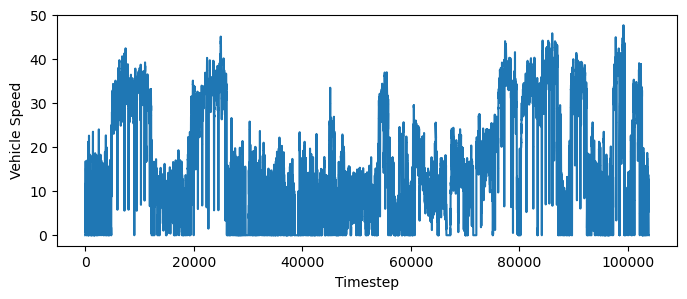

In [2]:
# load the dataset
df = pd.read_csv("all_LAT_uns.csv")

#print first 10 rows and descriptive statistics
print(df.head(10))
print(df.describe())

plt.rcParams['figure.figsize'] = [8, 3]

# you could plot the variables and observe their behavior
#can you trace any outlier?
plt.plot(df['locationSpeed'])
plt.xlabel('Timestep')
plt.ylabel('Vehicle Speed')

#create new feature 
# new single feature calculation
df['T'] = (1/9.81)*np.sqrt((df.loc[:, 'NewRotRateZ']**2)*(df.loc[:, 'locationSpeed'])**2 + (df.loc[:, 'NewAccelX']**2))
df['T'].describe()




In [3]:
# function for visualizing results of outlier detection
def outlier_vis(var1, var2, var3, df, method):
    ''' arguments: df - the dataframe that should contain a column inicating if each row is an outlier
                    var1, var2, var3 - the variables to visualize
                    method - name of method whose outliers are visualized (column that contains the outliers label)'''
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(projection='3d')
    
    # plot normal data
    ax.scatter(df[df[method]==0][var1], df[df[method]==0][var2], df[df[method]==0][var3], color = "b", s=3)
    # plot outlier values
    ax.scatter(df[df[method]==1][var1], df[df[method]==1][var2], df[df[method]==1][var3], color = "r", s=3)
    
    ax.set_xlabel(var2)
    ax.set_ylabel(var1)
    ax.set_zlabel(var3)
    
                

### Method 1: Boxplot (Interquantile Range - IQR)

A boxplot contains a lot of condensed information about the distribution of a variable (quantiles, mean and median values). In addition, it provides a way to detect outliers in a sample: The distance between the 1st (25%) and 3rd quantile (75%) is called interquantile range (IQR). Values that are lower than Q1-1.5IQR or higher than Q3+1.5IQR are considered as outliers.
The drawback of this method is that it takes into account only one variable at a time.
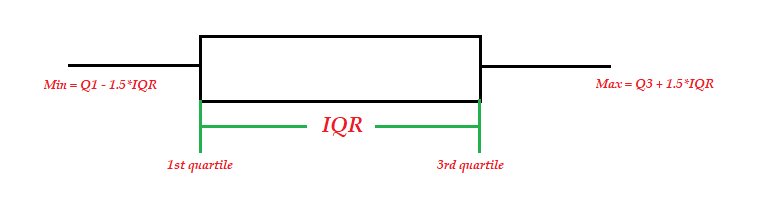

In [4]:
#Example based on variable T
q1 = df['T'].quantile(0.25)
q3 = df['T'].quantile(0.75)
iqr = q3-q1
print("IQR =",iqr)

IQR = 0.041687122944857234


Number of detected outliers: 11028


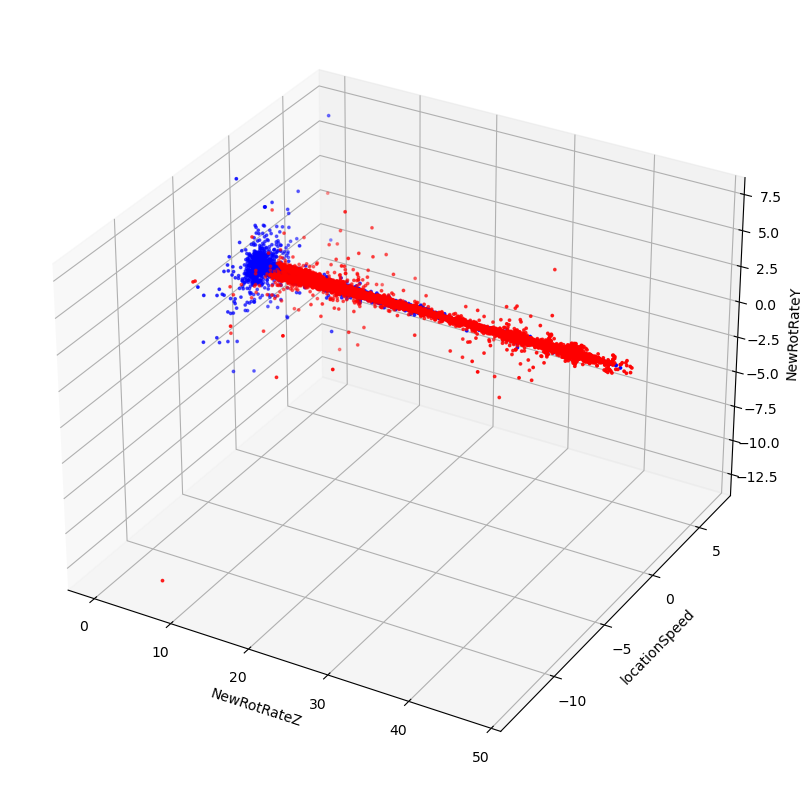

In [5]:
# create a new column with value 1 for outliers and 0 for the rest
df['bplot'] = ((df['T']<q1-1.5*iqr) | (df['T']>q3+1.5*iqr))

# call the function for visualizing
outlier_vis('locationSpeed','NewRotRateZ', 'NewRotRateY', df,'bplot') #experiment with other columns as well

print("Number of detected outliers:", df['bplot'].sum())

### Method 2: Z-score

Z-score is a statistical measure that tells you how far is a data point from the rest of the dataset. In a more technical term, Z-score tells how many standard deviations away a given observation is from the mean. Then, a threshold for the value of Z-score should be defined, in order to detect the outliers.
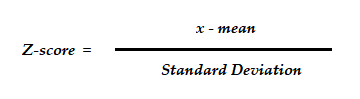

In [6]:
# calculate the Z-score for "T"
mean = df['T'].mean()
std_dev = df['T'].std()
df['Z-score'] = abs(df['T']-mean)/std_dev

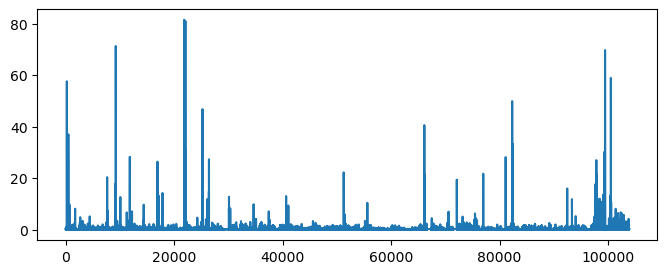

In [7]:
# plot the Z-score values in order to intuitively (visually) choose a proper threshold
plt.plot(df['Z-score'])

Number of detected outliers: 1223


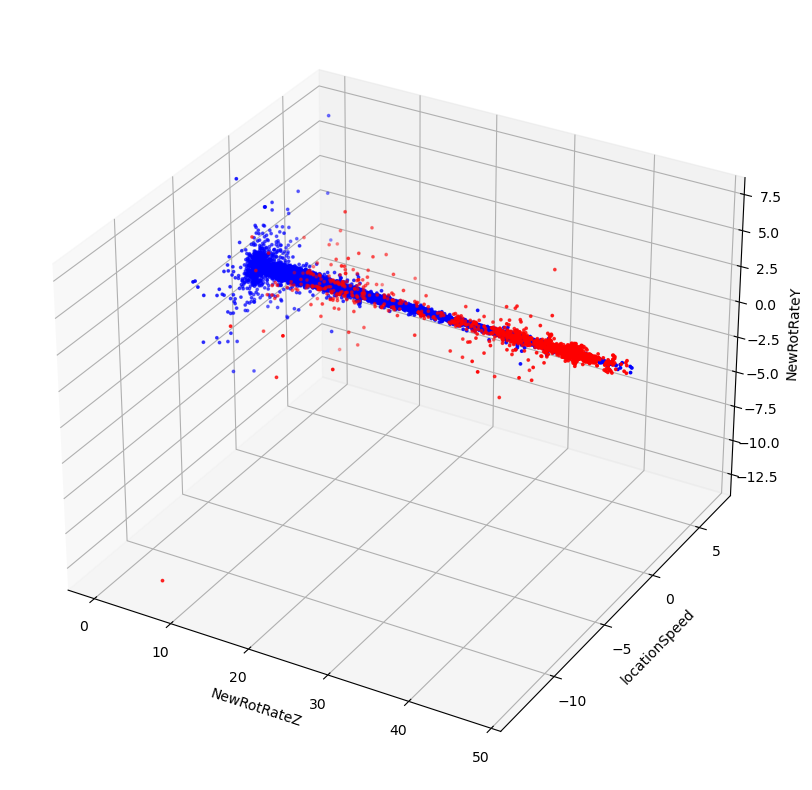

In [8]:
threshold = 2

# create a new column with value 1 for outliers and 0 for the rest
df['zscore'] = df['Z-score'] > threshold

# call the function for visualizing
outlier_vis('locationSpeed','NewRotRateZ', 'NewRotRateY', df,'zscore')

print("Number of detected outliers:", df['zscore'].sum())


### Method 3: k Nearest Neighbors (kNN)

kNN is an algorithm that is usually used for classification. For the task of outlier detection, one can use the mean value of the calculated distances between each individual and its k-neighbors; the higher the the mean distance value, the most possible is that the specific instance is an outlier. Compared to the two previous methods, it has the advantage that all variables are taken into account.

In [9]:
# instantiate model
knn = NearestNeighbors(n_neighbors = 200)
# fit model
x = df[['locationSpeed','T']] # use only relevant columns

knn.fit(x)

# get distances
dist, _ = knn.kneighbors(x)

# save mean value of distances in df
df['mean_dist_knn'] = dist.mean(axis=1)

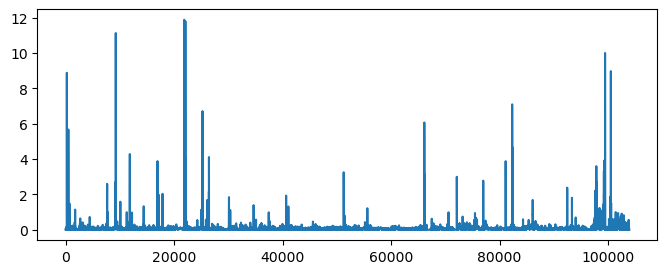

In [10]:
# plot in order to visually choose a threshold
plt.plot(df['mean_dist_knn'])

Number of detected outliers: 9353


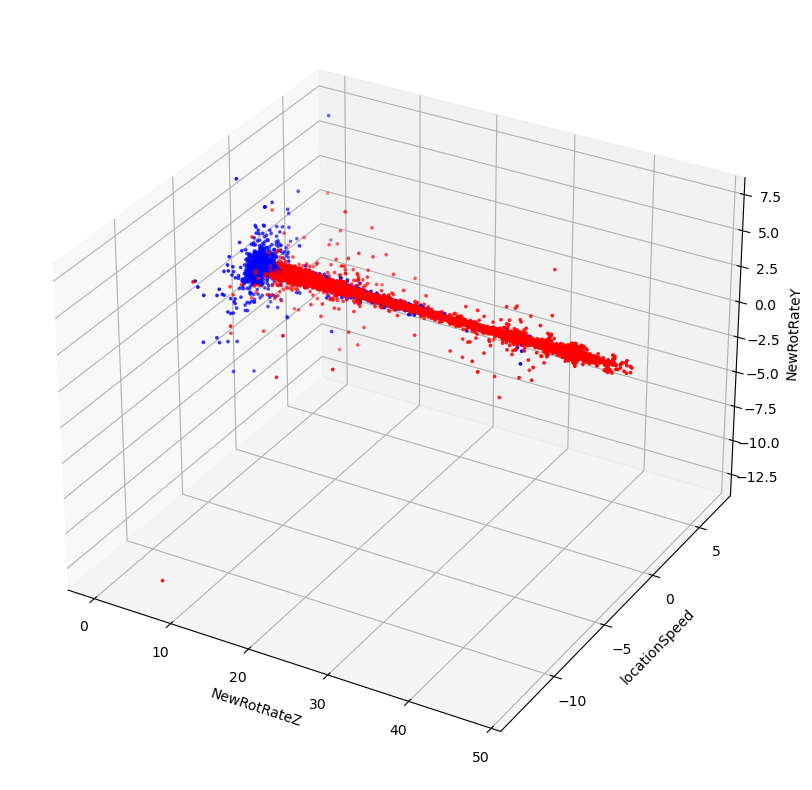

In [11]:
threshold = 0.09

# create a new column with value 1 for outliers and 0 for the rest
df['knn'] = df['mean_dist_knn'] > threshold

# call the function for visualizing
outlier_vis('locationSpeed','NewRotRateZ', 'NewRotRateY', df,'knn')

print("Number of detected outliers:", df['knn'].sum())

### Method 4: Local Outlier Factor (LOF)

LOF is an algorithm for outlier detection, that shares common characteristics with clustering algorithms, such as DBSCAN. LOF uses k nearest neighbors mean distance to estimate the local density of each individual instance. By comparing the local density of one point to those of its neighbors, one can identify regions of similar density, as well as points with significantly lower density than their neighbors. These latter points are considered as outliers. 

In [12]:
# instantiate model
lof = LOF(n_neighbors=200)

# fit model and detect outliers (LOF library returns -1 for outliers and 1 for other data)
lof_outliers = lof.fit_predict(x)

# similarly to the other methods, we convert to 1 for outliers and 0 for the rest of the data
df['lof'] = (lof_outliers==-1)

Number of detected outliers: 7845


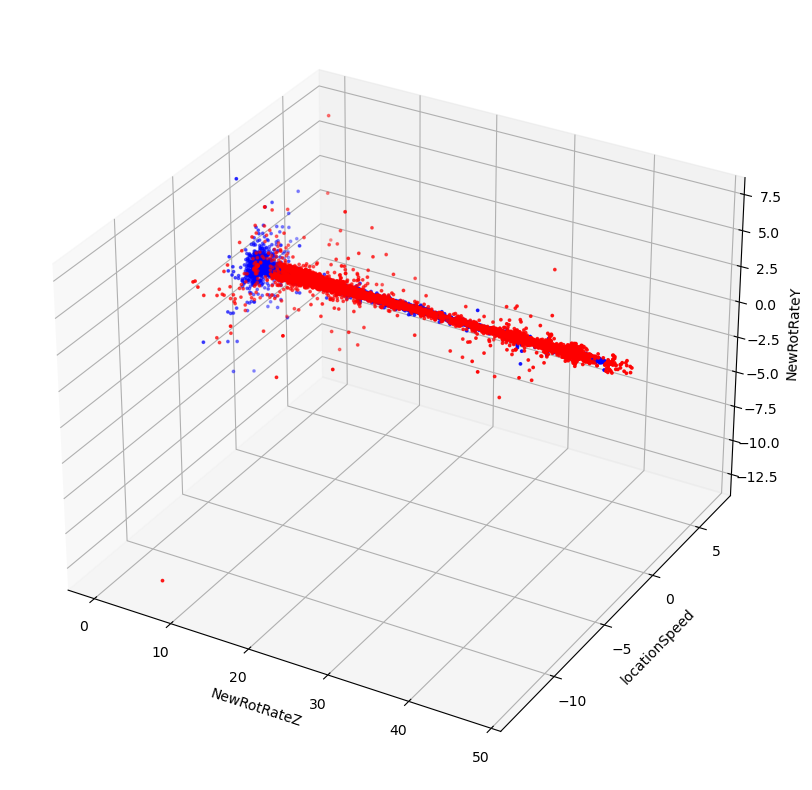

In [13]:
# call the function for visualizing
outlier_vis('locationSpeed','NewRotRateZ', 'NewRotRateY', df,'lof')

print("Number of detected outliers:", df['lof'].sum())

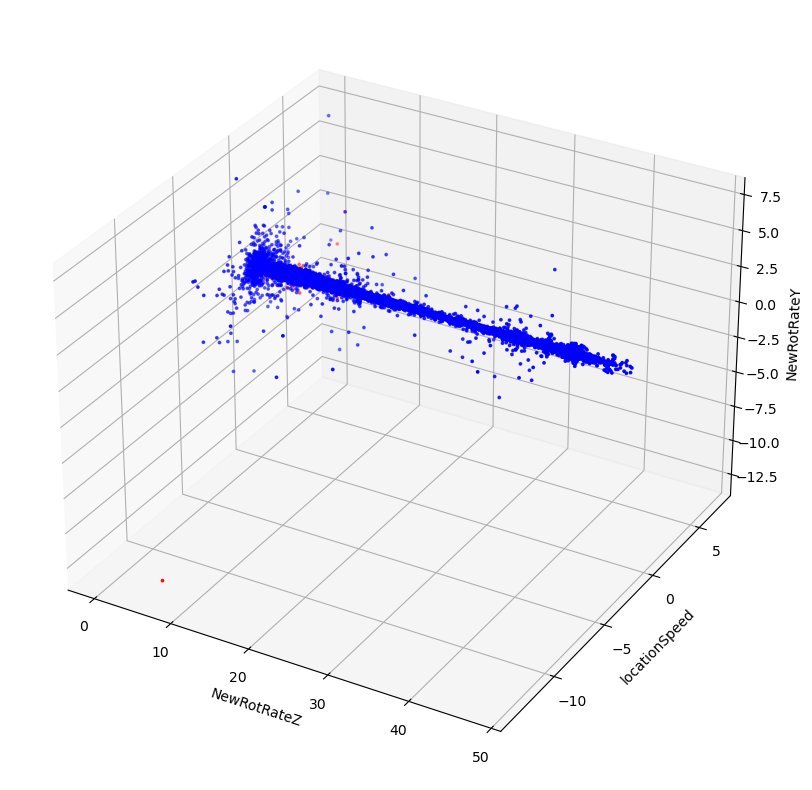

In [14]:
# compare with actual outliers

# load real values
df['real_values'] = pd.read_csv('all_LAT_un_results (1).csv',delimiter=';')['LATERAL']

# visualize actual outliers
outlier_vis('locationSpeed','NewRotRateZ', 'NewRotRateY', df,'real_values')

In [15]:
# for each method find the number of actual ouliers that were detected and the number of the instances that were 
# wrongly identified as outliers

print("The actual number of outliers is:", len(df[(df['real_values']==1)]))

print("Box plot")
df1 = df[(df['real_values']==1) & (df['bplot']==1)] # true positive
print("Correctly detected:", len(df1)) 
df2 = df[(df['real_values']==0) & (df['bplot']==1)] # false positive
print("Falsely detected:", len(df2))

print("Z-score")
df1 = df[(df['real_values']==1) & (df['zscore']==1)] # true positive
print("Correctly detected:", len(df1)) 
df2 = df[(df['real_values']==0) & (df['zscore']==1)] # false positive
print("Falsely detected:", len(df2))

print("kNN")
df1 = df[(df['real_values']==1) & (df['knn']==1)] # true positive
print("Correctly detected:", len(df1)) 
df2 = df[(df['real_values']==0) & (df['knn']==1)] # false positive
print("Falsely detected:", len(df2))

print("LOF")
df1 = df[(df['real_values']==1) & (df['lof']==1)] # true positive
print("Correctly detected:", len(df1)) 
df2 = df[(df['real_values']==0) & (df['lof']==1)] # false positive
print("Falsely detected:", len(df2))

The actual number of outliers is: 575
Box plot
Correctly detected: 366
Falsely detected: 10662
Z-score
Correctly detected: 23
Falsely detected: 1200
kNN
Correctly detected: 329
Falsely detected: 9024
LOF
Correctly detected: 370
Falsely detected: 7475


In [182]:
df.to_csv("results.csv")